# Improvements to a Neural Network

In a previous notebook we implemented a simple feedforward neural network and used it to classify handwritten digits. In this notebook we modify the simple network, adding several improvements which improve the accuracy of the network. As before, the code in this notebook is an adaption of the code (network2.py) included with the book "[Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)" by Michael Nielsen, specifically the [version and adapted to work with Python 3](https://github.com/MichalDanielDobrzanski/DeepLearningPython) by Michal Daniel Dobrzanski.

## Implementation of the Network

### Helpful libraries and convenience functions

First, we load some standard Python libraries.

In [37]:
import json
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from imp import reload

Define a convenience function for identifying which digit the network recognised.

In [2]:
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the j'th position
    and zeroes elsewhere.  This is used to convert a digit (0...9)
    into a corresponding desired output from the neural network.

    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

A function for loading a previously-saved network.

In [3]:
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

### Activation function

We now define our activation function and another function to compute its derivative

In [4]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

### Cost functions

We will be adding support in our Network class for different choices of cost function. For this, a cost function should be defined as a class  with two functions:
* fn(a, y): compute the cost for a given a and y
* delta: compute the error, $\delta^L$ in the output layer.

We now define two specific cost functions

#### Quadratic cost

In [5]:
class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.

        """
        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer."""
        return (a-y) * sigmoid_prime(z)

####  Cross-entropy cost

In [6]:
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)

### Network class

Next, we define a class "Network" that will represent our neural network. This includes several modifications to the previous class, primarily to allow for different cost functions, regularization, better weight initialization, and early stopping.

In [7]:
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the respective
        layers of the network.  For example, if the list was [2, 3, 1]
        then it would be a three-layer network, with the first layer
        containing 2 neurons, the second layer 3 neurons, and the
        third layer 1 neuron.  The biases and weights for the network
        are initialized randomly, using
        ``self.default_weight_initializer`` (see docstring for that
        method).

        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        """Initialize each weight using a Gaussian distribution with mean 0
        and standard deviation 1 over the square root of the number of
        weights connecting to the same neuron.  Initialize the biases
        using a Gaussian distribution with mean 0 and standard
        deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        """Initialize the weights using a Gaussian distribution with mean 0
        and standard deviation 1.  Initialize the biases using a
        Gaussian distribution with mean 0 and standard deviation 1.

        Note that the first layer is assumed to be an input layer, and
        by convention we won't set any biases for those neurons, since
        biases are only ever used in computing the outputs from later
        layers.

        This weight and bias initializer uses the same approach as in
        Chapter 1, and is included for purposes of comparison.  It
        will usually be better to use the default weight initializer
        instead.

        """
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            early_stopping_n = 0):
        """Train the neural network using mini-batch stochastic gradient
        descent.  The ``training_data`` is a list of tuples ``(x, y)``
        representing the training inputs and the desired outputs.  The
        other non-optional parameters are self-explanatory, as is the
        regularization parameter ``lmbda``.  The method also accepts
        ``evaluation_data``, usually either the validation or test
        data.  We can monitor the cost and accuracy on either the
        evaluation data or the training data, by setting the
        appropriate flags.  The method returns a tuple containing four
        lists: the (per-epoch) costs on the evaluation data, the
        accuracies on the evaluation data, the costs on the training
        data, and the accuracies on the training data.  All values are
        evaluated at the end of each training epoch.  So, for example,
        if we train for 30 epochs, then the first element of the tuple
        will be a 30-element list containing the cost on the
        evaluation data at the end of each epoch. Note that the lists
        are empty if the corresponding flag is not set.

        """

        # early stopping functionality:
        best_accuracy=1

        training_data = list(training_data)
        n = len(training_data)

        if evaluation_data:
            evaluation_data = list(evaluation_data)
            n_data = len(evaluation_data)

        # early stopping functionality:
        best_accuracy=0
        no_accuracy_change=0

        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))

            print("Epoch %s training complete" % j)

            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(self.accuracy(evaluation_data), n_data))

            # Early stopping:
            if early_stopping_n > 0:
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    no_accuracy_change = 0
                    #print("Early-stopping: Best so far {}".format(best_accuracy))
                else:
                    no_accuracy_change += 1

                if (no_accuracy_change == early_stopping_n):
                    #print("Early-stopping: No accuracy change in last epochs: {}".format(early_stopping_n))
                    return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

        return evaluation_cost, evaluation_accuracy, \
            training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying gradient
        descent using backpropagation to a single mini batch.  The
        ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the
        learning rate, ``lmbda`` is the regularization parameter, and
        ``n`` is the total size of the training data set.

        """
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.

        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.  More details on the
        representations can be found in
        mnist_loader.load_data_wrapper.

        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results)
        return result_accuracy

    def total_cost(self, data, lmbda, convert=False):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
            cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights) # '**' - to the power of.
        return cost

    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

## Example

We now look at a simple example, running the new network with the quadratic cost function, no regularization and the original method for initializing the weights. First, we load the training data:

In [53]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [9]:
net = Network([784, 30, 10], cost=QuadraticCost)
net.large_weight_initializer()
net.SGD(training_data, 10, 10, 3.0, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9071 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9231 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9315 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9323 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9366 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9409 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9434 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9434 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9427 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9445 / 10000


([], [9071, 9231, 9315, 9323, 9366, 9409, 9434, 9434, 9427, 9445], [], [])

## Exercises

### Cross-entropy cost function
1. Train network with a single hidden layer with 30 neurons using the cross-entropy cost function. Note: you should use a different learning rate to produce comparable results. A good rule of thumb is to reduce the rate by a factor of 6 when using a cross-entropy cost function compared to a quadratic cost function.
2. Compare the accuracy against the quadratic cost case.
3. Repeat, but with 100 neurons.

### Overfitting and regularization
1. Train a 30 neuron network with a 1000-sample subset of the MNIST training data. Use the cross-entropy cost function and train for 400 epochs. Enabe monitoring of the evaluation accuracy and training cost and plot the results.
2. Train the network again, but this time including regularization by setting `lmbda=0.1`.
3. Compare the results in the two cases.


### Weight initialization
1. Train your network again, but this time use the improved `default_weight_initializer` weight initialization.
2. Compare the accuracy with previous cases.

In [52]:
net1 = Network([784, 30, 10], cost=CrossEntropyCost)
net1.large_weight_initializer()
net1.SGD(training_data, 10, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9185 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9300 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9321 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9326 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9412 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9422 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9411 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9391 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9437 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9477 / 10000


([], [9185, 9300, 9321, 9326, 9412, 9422, 9411, 9391, 9437, 9477], [], [])

Very similar accuracy!

In [18]:
net2 = Network([784, 100, 10], cost=CrossEntropyCost)
net2.large_weight_initializer()
net2.SGD(training_data, 10, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9324 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9455 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9505 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9544 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9570 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9617 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9614 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9584 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9627 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9624 / 10000


([], [9324, 9455, 9505, 9544, 9570, 9617, 9614, 9584, 9627, 9624], [], [])

In [22]:
sample_training_data = random.sample(list(training_data), 1000)
net3 = Network([784, 30, 10], cost=CrossEntropyCost)
net3.large_weight_initializer()
(e1, eacc, tcost, e2) = net3.SGD(sample_training_data, 400, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True,
         monitor_training_cost=True)

epoch = np.arange(0, 400, 1)

Epoch 0 training complete
Cost on training data: 1.6816634101642325
Accuracy on evaluation data: 6484 / 10000
Epoch 1 training complete
Cost on training data: 1.274145794033135
Accuracy on evaluation data: 7138 / 10000
Epoch 2 training complete
Cost on training data: 1.071955809428931
Accuracy on evaluation data: 7538 / 10000
Epoch 3 training complete
Cost on training data: 0.8675465113435847
Accuracy on evaluation data: 7778 / 10000
Epoch 4 training complete
Cost on training data: 0.752451673473784
Accuracy on evaluation data: 7941 / 10000
Epoch 5 training complete
Cost on training data: 0.641394009557749
Accuracy on evaluation data: 8001 / 10000
Epoch 6 training complete
Cost on training data: 0.5707613249571466
Accuracy on evaluation data: 8074 / 10000
Epoch 7 training complete
Cost on training data: 0.5141960918793983
Accuracy on evaluation data: 8061 / 10000
Epoch 8 training complete
Cost on training data: 0.4640468319555213
Accuracy on evaluation data: 8083 / 10000
Epoch 9 traini

Accuracy on evaluation data: 8386 / 10000
Epoch 74 training complete
Cost on training data: 0.028589660563646868
Accuracy on evaluation data: 8387 / 10000
Epoch 75 training complete
Cost on training data: 0.02806223521386996
Accuracy on evaluation data: 8380 / 10000
Epoch 76 training complete
Cost on training data: 0.02763998335739299
Accuracy on evaluation data: 8388 / 10000
Epoch 77 training complete
Cost on training data: 0.027205580425462495
Accuracy on evaluation data: 8377 / 10000
Epoch 78 training complete
Cost on training data: 0.026811577203099433
Accuracy on evaluation data: 8386 / 10000
Epoch 79 training complete
Cost on training data: 0.026341028875390016
Accuracy on evaluation data: 8387 / 10000
Epoch 80 training complete
Cost on training data: 0.02592272081582061
Accuracy on evaluation data: 8383 / 10000
Epoch 81 training complete
Cost on training data: 0.02556622603213043
Accuracy on evaluation data: 8381 / 10000
Epoch 82 training complete
Cost on training data: 0.025125

Cost on training data: 0.0119336609634564
Accuracy on evaluation data: 8419 / 10000
Epoch 147 training complete
Cost on training data: 0.011841353985935547
Accuracy on evaluation data: 8431 / 10000
Epoch 148 training complete
Cost on training data: 0.011747388645864934
Accuracy on evaluation data: 8426 / 10000
Epoch 149 training complete
Cost on training data: 0.011654382156197988
Accuracy on evaluation data: 8428 / 10000
Epoch 150 training complete
Cost on training data: 0.01156850088228419
Accuracy on evaluation data: 8425 / 10000
Epoch 151 training complete
Cost on training data: 0.011476082771137272
Accuracy on evaluation data: 8427 / 10000
Epoch 152 training complete
Cost on training data: 0.011388451812819247
Accuracy on evaluation data: 8429 / 10000
Epoch 153 training complete
Cost on training data: 0.011301188859473177
Accuracy on evaluation data: 8430 / 10000
Epoch 154 training complete
Cost on training data: 0.011216102742130661
Accuracy on evaluation data: 8426 / 10000
Epoch

Cost on training data: 0.007527615696945152
Accuracy on evaluation data: 8443 / 10000
Epoch 219 training complete
Cost on training data: 0.007488495635846667
Accuracy on evaluation data: 8444 / 10000
Epoch 220 training complete
Cost on training data: 0.00744891857263188
Accuracy on evaluation data: 8446 / 10000
Epoch 221 training complete
Cost on training data: 0.0074101009741142036
Accuracy on evaluation data: 8443 / 10000
Epoch 222 training complete
Cost on training data: 0.007371807524404789
Accuracy on evaluation data: 8441 / 10000
Epoch 223 training complete
Cost on training data: 0.007334742595675477
Accuracy on evaluation data: 8441 / 10000
Epoch 224 training complete
Cost on training data: 0.0072966320648681195
Accuracy on evaluation data: 8444 / 10000
Epoch 225 training complete
Cost on training data: 0.007259293738041097
Accuracy on evaluation data: 8443 / 10000
Epoch 226 training complete
Cost on training data: 0.007222941967802817
Accuracy on evaluation data: 8443 / 10000
E

Cost on training data: 0.005453126391353615
Accuracy on evaluation data: 8433 / 10000
Epoch 291 training complete
Cost on training data: 0.005432310200306014
Accuracy on evaluation data: 8436 / 10000
Epoch 292 training complete
Cost on training data: 0.005412192350330609
Accuracy on evaluation data: 8432 / 10000
Epoch 293 training complete
Cost on training data: 0.00539181356893824
Accuracy on evaluation data: 8432 / 10000
Epoch 294 training complete
Cost on training data: 0.005371916880352542
Accuracy on evaluation data: 8432 / 10000
Epoch 295 training complete
Cost on training data: 0.005351838316713436
Accuracy on evaluation data: 8438 / 10000
Epoch 296 training complete
Cost on training data: 0.005331880438135829
Accuracy on evaluation data: 8436 / 10000
Epoch 297 training complete
Cost on training data: 0.005312386950351359
Accuracy on evaluation data: 8432 / 10000
Epoch 298 training complete
Cost on training data: 0.005292788809422743
Accuracy on evaluation data: 8433 / 10000
Epo

Cost on training data: 0.004284678568662308
Accuracy on evaluation data: 8440 / 10000
Epoch 363 training complete
Cost on training data: 0.004271847476627783
Accuracy on evaluation data: 8439 / 10000
Epoch 364 training complete
Cost on training data: 0.004259203681272445
Accuracy on evaluation data: 8439 / 10000
Epoch 365 training complete
Cost on training data: 0.004246589183477922
Accuracy on evaluation data: 8439 / 10000
Epoch 366 training complete
Cost on training data: 0.004234120114705811
Accuracy on evaluation data: 8440 / 10000
Epoch 367 training complete
Cost on training data: 0.004221630249878625
Accuracy on evaluation data: 8439 / 10000
Epoch 368 training complete
Cost on training data: 0.004209185980665852
Accuracy on evaluation data: 8442 / 10000
Epoch 369 training complete
Cost on training data: 0.00419671491866612
Accuracy on evaluation data: 8440 / 10000
Epoch 370 training complete
Cost on training data: 0.004184542361306069
Accuracy on evaluation data: 8441 / 10000
Epo

NameError: name 'plt' is not defined

Text(0, 0.5, 'Evaluation Accuracy')

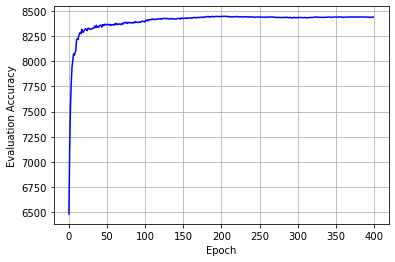

In [40]:
plt.plot(epoch, eacc, 'b-')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Evaluation Accuracy')

Text(0.5, 0, 'Epoch')

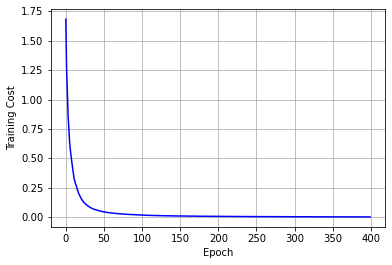

In [39]:
plt.plot(epoch, tcost, 'b-')
plt.grid()
plt.ylabel('Training Cost')
plt.xlabel('Epoch')

In [45]:
sample_training_data = random.sample(list(training_data), 1000)
net4 = Network([784, 30, 10], cost=CrossEntropyCost)
net4.large_weight_initializer()
(e3, eacc2, tcost2, e4) = net4.SGD(sample_training_data, 400, 10, 0.5,lmbda=0.1,
                                   evaluation_data=test_data, monitor_evaluation_accuracy=True,
                                   monitor_training_cost=True)

epoch2 = np.arange(0, 400, 1)

Epoch 0 training complete
Cost on training data: 1166.5300116458018
Accuracy on evaluation data: 5755 / 10000
Epoch 1 training complete
Cost on training data: 1156.3881685943072
Accuracy on evaluation data: 6495 / 10000
Epoch 2 training complete
Cost on training data: 1146.795700750023
Accuracy on evaluation data: 7313 / 10000
Epoch 3 training complete
Cost on training data: 1137.7145953755792
Accuracy on evaluation data: 7559 / 10000
Epoch 4 training complete
Cost on training data: 1128.8042222261624
Accuracy on evaluation data: 7687 / 10000
Epoch 5 training complete
Cost on training data: 1120.0935425101636
Accuracy on evaluation data: 7778 / 10000
Epoch 6 training complete
Cost on training data: 1111.4858867502878
Accuracy on evaluation data: 7958 / 10000
Epoch 7 training complete
Cost on training data: 1102.9949785851777
Accuracy on evaluation data: 8075 / 10000
Epoch 8 training complete
Cost on training data: 1094.555029033318
Accuracy on evaluation data: 8146 / 10000
Epoch 9 trai

Accuracy on evaluation data: 8531 / 10000
Epoch 75 training complete
Cost on training data: 624.8983822628373
Accuracy on evaluation data: 8533 / 10000
Epoch 76 training complete
Cost on training data: 619.5894466368487
Accuracy on evaluation data: 8527 / 10000
Epoch 77 training complete
Cost on training data: 614.3594830534335
Accuracy on evaluation data: 8539 / 10000
Epoch 78 training complete
Cost on training data: 609.1655462896833
Accuracy on evaluation data: 8522 / 10000
Epoch 79 training complete
Cost on training data: 604.0116645487429
Accuracy on evaluation data: 8525 / 10000
Epoch 80 training complete
Cost on training data: 598.9108529507295
Accuracy on evaluation data: 8532 / 10000
Epoch 81 training complete
Cost on training data: 593.853891671809
Accuracy on evaluation data: 8527 / 10000
Epoch 82 training complete
Cost on training data: 588.8510618809291
Accuracy on evaluation data: 8531 / 10000
Epoch 83 training complete
Cost on training data: 583.8814744541701
Accuracy on

Accuracy on evaluation data: 8655 / 10000
Epoch 149 training complete
Cost on training data: 341.56444204495165
Accuracy on evaluation data: 8648 / 10000
Epoch 150 training complete
Cost on training data: 338.95229756352603
Accuracy on evaluation data: 8645 / 10000
Epoch 151 training complete
Cost on training data: 336.35593582947104
Accuracy on evaluation data: 8654 / 10000
Epoch 152 training complete
Cost on training data: 333.79302235454696
Accuracy on evaluation data: 8661 / 10000
Epoch 153 training complete
Cost on training data: 331.2482216317199
Accuracy on evaluation data: 8671 / 10000
Epoch 154 training complete
Cost on training data: 328.73644508677654
Accuracy on evaluation data: 8664 / 10000
Epoch 155 training complete
Cost on training data: 326.238147565723
Accuracy on evaluation data: 8652 / 10000
Epoch 156 training complete
Cost on training data: 323.77306015311564
Accuracy on evaluation data: 8672 / 10000
Epoch 157 training complete
Cost on training data: 321.3283336513

Cost on training data: 204.50652995959496
Accuracy on evaluation data: 8750 / 10000
Epoch 223 training complete
Cost on training data: 203.22928682042635
Accuracy on evaluation data: 8749 / 10000
Epoch 224 training complete
Cost on training data: 201.95963362949027
Accuracy on evaluation data: 8755 / 10000
Epoch 225 training complete
Cost on training data: 200.71617315854436
Accuracy on evaluation data: 8754 / 10000
Epoch 226 training complete
Cost on training data: 199.47928594060812
Accuracy on evaluation data: 8758 / 10000
Epoch 227 training complete
Cost on training data: 198.24908045955624
Accuracy on evaluation data: 8748 / 10000
Epoch 228 training complete
Cost on training data: 197.0305855550947
Accuracy on evaluation data: 8754 / 10000
Epoch 229 training complete
Cost on training data: 195.8257804593582
Accuracy on evaluation data: 8756 / 10000
Epoch 230 training complete
Cost on training data: 194.64439633226314
Accuracy on evaluation data: 8763 / 10000
Epoch 231 training com

Accuracy on evaluation data: 8806 / 10000
Epoch 296 training complete
Cost on training data: 137.398852621947
Accuracy on evaluation data: 8803 / 10000
Epoch 297 training complete
Cost on training data: 136.78959629716937
Accuracy on evaluation data: 8808 / 10000
Epoch 298 training complete
Cost on training data: 136.1826108003856
Accuracy on evaluation data: 8809 / 10000
Epoch 299 training complete
Cost on training data: 135.58552038018854
Accuracy on evaluation data: 8812 / 10000
Epoch 300 training complete
Cost on training data: 134.99061659400127
Accuracy on evaluation data: 8806 / 10000
Epoch 301 training complete
Cost on training data: 134.4080870098868
Accuracy on evaluation data: 8801 / 10000
Epoch 302 training complete
Cost on training data: 133.83294005085403
Accuracy on evaluation data: 8811 / 10000
Epoch 303 training complete
Cost on training data: 133.2404495585169
Accuracy on evaluation data: 8803 / 10000
Epoch 304 training complete
Cost on training data: 132.680198209457

Cost on training data: 105.46121190793694
Accuracy on evaluation data: 8827 / 10000
Epoch 370 training complete
Cost on training data: 105.1526466611425
Accuracy on evaluation data: 8835 / 10000
Epoch 371 training complete
Cost on training data: 104.86159532414705
Accuracy on evaluation data: 8832 / 10000
Epoch 372 training complete
Cost on training data: 104.57026752752739
Accuracy on evaluation data: 8824 / 10000
Epoch 373 training complete
Cost on training data: 104.2807050976962
Accuracy on evaluation data: 8831 / 10000
Epoch 374 training complete
Cost on training data: 103.9818787291438
Accuracy on evaluation data: 8838 / 10000
Epoch 375 training complete
Cost on training data: 103.69856253251129
Accuracy on evaluation data: 8813 / 10000
Epoch 376 training complete
Cost on training data: 103.42187333232587
Accuracy on evaluation data: 8833 / 10000
Epoch 377 training complete
Cost on training data: 103.14497383416224
Accuracy on evaluation data: 8823 / 10000
Epoch 378 training comp

Text(0, 0.5, 'Evaluation Accuracy')

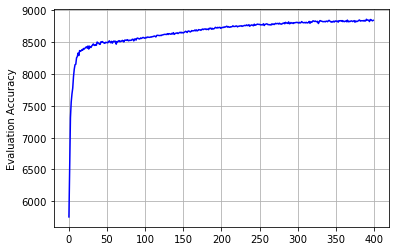

In [48]:
plt.plot(epoch2, eacc2, 'b-')
plt.grid()
plt.xlabel=('Epoch')
plt.ylabel('Evaluation Accuracy')

Text(0, 0.5, 'Training Cost')

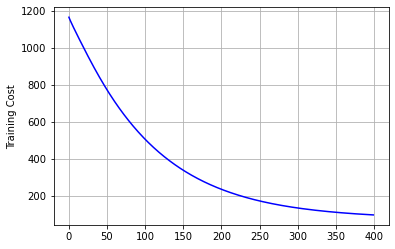

In [49]:
plt.plot(epoch2, tcost2, 'b-')
plt.grid()
plt.xlabel=('Epoch')
plt.ylabel('Training Cost')

Accuracy becomes better, and the cost changes more continously throughout the training!

In [54]:
net5 = Network([784, 30, 10], cost=CrossEntropyCost)
net5.default_weight_initializer()
net5.SGD(training_data, 10, 10, 0.5, evaluation_data=test_data, monitor_evaluation_accuracy=True)

Epoch 0 training complete
Accuracy on evaluation data: 9385 / 10000
Epoch 1 training complete
Accuracy on evaluation data: 9466 / 10000
Epoch 2 training complete
Accuracy on evaluation data: 9488 / 10000
Epoch 3 training complete
Accuracy on evaluation data: 9521 / 10000
Epoch 4 training complete
Accuracy on evaluation data: 9527 / 10000
Epoch 5 training complete
Accuracy on evaluation data: 9538 / 10000
Epoch 6 training complete
Accuracy on evaluation data: 9522 / 10000
Epoch 7 training complete
Accuracy on evaluation data: 9554 / 10000
Epoch 8 training complete
Accuracy on evaluation data: 9545 / 10000
Epoch 9 training complete
Accuracy on evaluation data: 9537 / 10000


([], [9385, 9466, 9488, 9521, 9527, 9538, 9522, 9554, 9545, 9537], [], [])

Starts much better! Therefor reaches a better accuracy, but still has it's limits!